### Classify Twin/Non-Twin Status from Brain Data

The goal of this analysis is to test if we can classify whether a dyad is from twins or no-twins based on their functional brain response similarity (i.e. ISC). In this case, we're computing ISC for all regions and use them all as features. One could narrow this down to only a set of regions, i.e. apply feature selection. 

#### Import modules

In [59]:
import sys, os, nilearn, pickle, glob, shutil, itertools, random, warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, LeaveOneOut
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline
warnings.simplefilter("ignore")

#### Reading in Twin-list and computing ISC among twins

In [60]:
twin_df = pd.read_csv('../data/00_dataset_info/twin_df.csv')
twin_list = twin_df[['twin_A_id','twin_B_id']].values.tolist()
print(twin_list[:3])

n_twins = len(twin_df)

n_regions       = 293

twin_df.head()

[['sub-0001', 'sub-0018'], ['sub-0003', 'sub-0233'], ['sub-0004', 'sub-0420']]


,Unnamed: 0,family_id,twin_A_id,twin_A_age,twin_A_sex,twin_B_id,twin_B_age,twin_B_sex
0,0,fam-0001,sub-0001,14.0,M,sub-0018,14.0,M
1,1,fam-0116,sub-0003,14.0,M,sub-0233,14.0,F
2,2,fam-0002,sub-0004,11.0,M,sub-0420,11.0,M
3,3,fam-0088,sub-0005,12.0,F,sub-0178,12.0,F
4,4,fam-0178,sub-0006,15.0,M,sub-0329,15.0,F


In [61]:
class_twin_notwin   = np.zeros((n_regions+1, n_twins, 2)) 
class_twin_notwin.shape

(294, 100, 2)

In [62]:
# Computing ISC (functional) for the real twins
n_twins         = len(twin_list)
class_twin_notwin   = np.zeros((n_regions+1, n_twins, 2)) #the additional line is for the anatomical similarity

region_count = []

for curr_region in tqdm(range(n_regions)):
    counter_twin_gt_notwin = 0
    counter_twin_lt_notwin = 0
    
    for  curr_twin in range(len(twin_list)):
        
        twin_pair  = twin_list[curr_twin]
        filename_1 = '../data/03_extract_ts_aus/' + twin_pair[0] + '_LTR_Z_THP001_LP012_shen268_pauli16_aan9.npy'
        twin1_data = np.load(filename_1) 
        
        filename_2 = '../data/03_extract_ts_aus/' + twin_pair[1] + '_LTR_Z_THP001_LP012_shen268_pauli16_aan9.npy'
        twin2_data = np.load(filename_2) 
        
        #from the remaining people, randomly chose one, excluding the actual twin
        other_twin_list = twin_df['twin_B_id'].values.tolist()
        other_people = [x for x in other_twin_list if x != twin_pair[1]]  
        no_twin_filename_1 = '../data/03_extract_ts_aus/' + random.choice(other_people) + '_LTR_Z_THP001_LP012_shen268_pauli16_aan9.npy'
        no_twin_data1 = np.load(no_twin_filename_1) 
 
        res_twins = np.corrcoef(twin1_data[:,curr_region], twin2_data[:,curr_region])[0,1]        
        res_notwins = np.corrcoef(twin1_data[:,curr_region], no_twin_data1[:,curr_region])[0,1]
        
        if (res_twins > res_notwins):
            counter_twin_gt_notwin = counter_twin_gt_notwin + 1
        else:
            counter_twin_lt_notwin = counter_twin_lt_notwin +1
            
        class_twin_notwin[curr_region, curr_twin, 0] = res_twins
        class_twin_notwin[curr_region, curr_twin, 1] = res_notwins
                
    region_count.append(counter_twin_gt_notwin - counter_twin_lt_notwin)

100%|███████████████████████████████████████████████████████████████████████████████████| 293/293 [00:22<00:00, 12.83it/s]


### prepare data for prediction

(200, 294)
(200,)


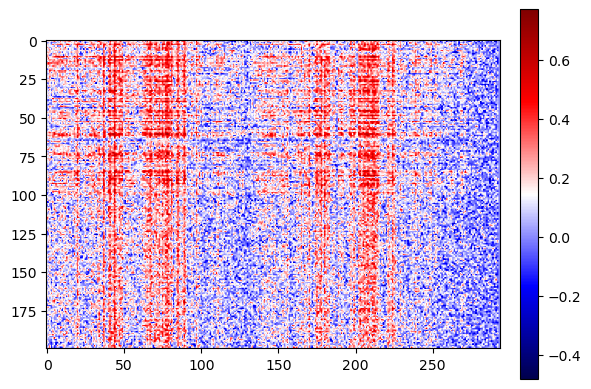

In [63]:
# X matrix contains data from twins/no-wrins
X = np.vstack( (class_twin_notwin[:,:,0].T , class_twin_notwin[:,:,1].T) ) #first is twins, second is from notwins
y = np.hstack((np.ones(n_twins), np.zeros(n_twins)))  #ones and zeros ...

print(X.shape)
print(y.shape)

plt.imshow(X, cmap = 'seismic'); #one can actually 'see the effect', i.e. more reddish in the top 100 !
plt.colorbar(fraction=0.046, pad=0.04);

In [65]:
# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# use stratified k-fold cross-validation to evaluate model
#cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create the cross validator: Reviewer request: Use LOO
cv = LeaveOneOut()

####  dummy

In [66]:
# create a dummy classifier for baseline performance
dummy = DummyClassifier(strategy='stratified')
scores = cross_val_score(dummy, X, y, cv=cv)

print("Cross-validation scores Dummy: ", scores)
print("Average score Dummy: ", scores.mean())

Cross-validation scores Dummy:  [0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1.
 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.
 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0.
 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0.
 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0.
 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0.
 0. 1. 0. 1. 1. 1. 0. 1.]
Average score Dummy:  0.505


####  actual model

In [67]:
# create a logistic regression model
model = LogisticRegression()
scores = cross_val_score(model, X, y, cv=cv)

print("Cross-validation scores: ", scores)
print("Average score: ", scores.mean())

Cross-validation scores:  [1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1.
 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1.
 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0.
 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1.
 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1.
 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1.
 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1.
 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1.
 1. 0. 1. 1. 1. 1. 1. 1.]
Average score:  0.635


In [68]:
# fit the model on the full training data
#model.fit(X_train, y_train)

# predict target variable for test data
#y_pred = model.predict(X_test)

# calculate accuracy of the model
#accuracy = accuracy_score(y_test, y_pred)

#print("Accuracy: ", accuracy)